# Challenge 


We expect you to: 
  - finish the test in 2-3 hours
  - return the results in 1 week but the sooner the better
  - build an end-to-end pipeline for the task
  - showcase your understanding of various aspects of ML: ETL, model building and selection, evaluation, etc.
  - develop in python (jupyter notebooks) with reasonable comments
  - use version control with appropriate commit messages

The test is about building a CTR prediction model with one of the datasets:
  - https://www.kaggle.com/c/online-advertising-challenge-spring-2018
  - https://www.kaggle.com/c/avazu-ctr-prediction
  - https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection
  - https://www.kaggle.com/c/criteo-display-ad-challenge

# Data 

For this exercise [Avazu dataset](https://www.kaggle.com/c/avazu-ctr-prediction/overview) is used. There is no particular reason for choosing one dataset over another. 

Data was downloaded from the link above and saved into the `data` folder. After decompressing, the files were renamed to *csv* extension. Please refer to the link for more data description. 

In [29]:
! head ./data/avazu-ctr-prediction/train.csv

In [30]:
# Reading the data with Dask - in parallel 
import dask.dataframe as dd

# Define schema dict; this will force schema when reding data. 
dict_schema = {'id': 'float64'}

train = dd.read_csv(urlpath='./data/avazu-ctr-prediction/train.csv', dtype = dict_schema)
test = dd.read_csv(urlpath='./data/avazu-ctr-prediction/test.csv', dtype = dict_schema)

# print data head and shape
print('train shape = {}'.format(train.compute().shape))
print('test shape = {}'.format(test.compute().shape))

display(train.head())

train shape = (40428967, 24)
test shape = (4577464, 23)


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [31]:
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [32]:
test.columns

Index(['id', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [33]:
type(train)

dask.dataframe.core.DataFrame

**NOTE**

**This dataset appears to be big enough to not accommodate light ML training on local machine. In this context, I will limit the analysis to 1M observations in the training dataset and the respective about 2.5% in the testing dataset.**

**This is a limitation when it comes to the accuracy of the model. I assume the task is not necessarily concerned with accuracy (even though this is important), but rather with building end to end ML and feature engineering. Having said that, I can certainly use the cloud for more computing resources, but this is not explored here.**

In [35]:
# Sample the data and save to disk
sample_fraction = 0.025
train_sample = train.sample(frac=sample_fraction)
train_sample.compute().to_csv('./data/avazu-ctr-prediction/train_sample.csv', index = None)

test_sample = test.sample(frac=sample_fraction)
test_sample.compute().to_csv('./data/avazu-ctr-prediction/test_sample.csv', index = None)

In [1]:
# Reading the data back -- not needed now; just in case you start fresh. 

# Reading the data with Dask - in parallel 
import dask.dataframe as dd
dict_schema = {'id': 'float64', 'hour': 'object'}

train_sample = dd.read_csv(urlpath='./data/avazu-ctr-prediction/train_sample.csv', dtype = dict_schema).compute()
test_sample = dd.read_csv(urlpath='./data/avazu-ctr-prediction/test_sample.csv', dtype = dict_schema).compute()

print('train sample shape = {}'.format(train_sample.shape))
print('test sample shape = {}'.format(test_sample.shape))

train sample shape = (1010725, 24)
test sample shape = (114436, 23)


# Data Exploration

The aim of this section is not to conduct an intensive EDA (this was addressed in previous exercise), but to explore feature distribution and how it relates to the CTR. 


In [2]:
# Check the data types
display(train_sample.dtypes)


id                  float64
click                 int64
hour                 object
C1                    int64
banner_pos            int64
site_id              object
site_domain          object
site_category        object
app_id               object
app_domain           object
app_category         object
device_id            object
device_ip            object
device_model         object
device_type           int64
device_conn_type      int64
C14                   int64
C15                   int64
C16                   int64
C17                   int64
C18                   int64
C19                   int64
C20                   int64
C21                   int64
dtype: object

**Notes:**

- *hour* will be converted into *datetime*. the other object columns are mostly related to categorical variables. 

In [3]:
import datetime

def convert_date (x):
   try:
      return datetime.datetime.strptime(x, '%y%m%d%H')
   except:
      return x


train_sample['hour'] = train_sample['hour'].apply(convert_date)
test_sample['hour'] = test_sample['hour'].apply(convert_date)

## CTR description

This section explores the CTR distribution in relation to main features. The assumption is that by describing the data, some correlations can be visually seen. This will hopefully aid feature engineering task later on. 

In [4]:
print("Overall CTR: ")
round(train_sample.click.value_counts() / train_sample.shape[0], 2)

# The overall CTR = ~17%

Overall CTR: 


0    0.83
1    0.17
Name: click, dtype: float64

**I hypothesize time in the day is quite important for the final prediction. Ideally, month and day in the month as well as hour is important. These features will be extracted, but the prediction will be based on limited data: 1M records.**

### CTR by Hour

In [5]:
# Based on the sample data, the hourly clicks (timeline) look similar with a few peaks, particularily on the 22nd and 28th of Oct.

import seaborn as sns
import matplotlib.pyplot as plt

train_sample.groupby('hour').agg({'click':'sum'}).plot(figsize=(14,7))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour / time');

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  """
/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  


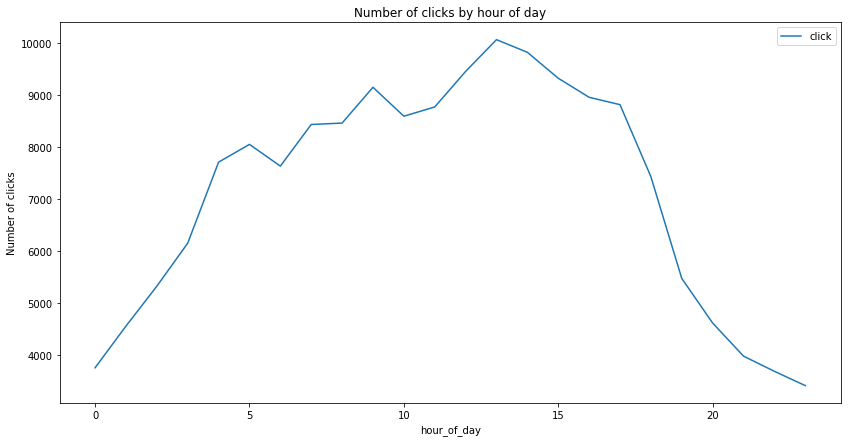

In [6]:
# The clicks distribution by hour of day looks quite different: Most of the clicks happen around midday and afternoon
# with least ones during the night. Business hours is as expected. 

train_sample['hour_of_day'] = train_sample['hour'].apply(lambda x: x.hour)
train_sample['day_name'] = train_sample['hour'].apply(lambda x: x.weekday_name)

test_sample['hour_of_day'] = test_sample['hour'].apply(lambda x: x.hour)
test_sample['day_name'] = test_sample['hour'].apply(lambda x: x.weekday_name)

train_sample.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=(14,7))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour of day');

Text(0,0.5,'CTR')

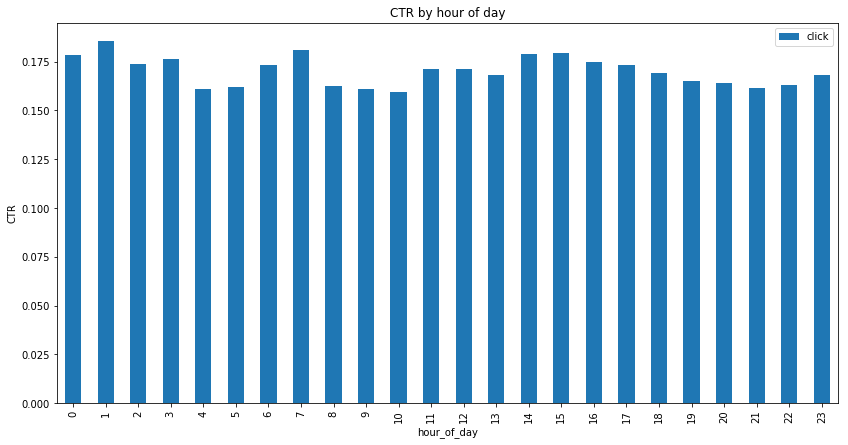

In [7]:
# There is consistency in terms of CTR by hour of the day with surprinsingly the highest value at hour 1am. 

def calculate_ctr(clicks):
    ctr = sum(clicks) / len(clicks)
    return ctr

train_sample.groupby('hour_of_day').agg({'click':calculate_ctr}).plot(kind='bar', figsize=(14,7))
plt.title('CTR by hour of day')
plt.ylabel('CTR')
    

Text(0,0.5,'CTR')

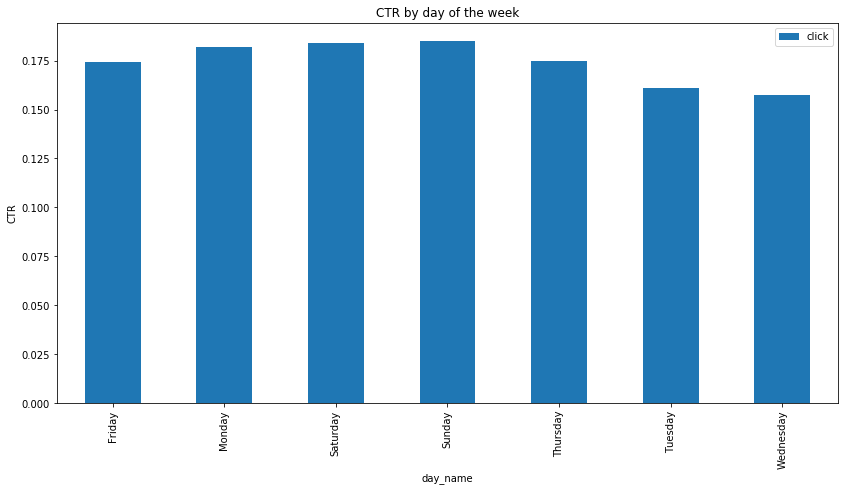

In [8]:
# The CTR is also consistent by day of the week, with weekend days having the highest values. 

train_sample.groupby('day_name').agg({'click':calculate_ctr}).plot(kind='bar', figsize=(14,7))
plt.title('CTR by day of the week')
plt.ylabel('CTR')


### CTR by other features - INTERACTIVE


**Notes:**

- below you can see top 20 categories with most impressions and related CTR scores. 

---



- **C1** categorical data shows that value 1002 has the higest CTR rate, but 92% of the values in this column are 1005. Adding more adds on value 1002 looks sensible. 
- 72% of the **banner position** is at position 0, but this does not relate to the highest CTR score. Pos 7 has the highest CTR score. Increasing the number of ads placed on banner position 7 seems to be a good idea.
- the **site feateures** shows various distribution as related to the CTR score with some scores very high (i.e. 70%)
- **device**
    - 82% of the impressions are seen on one device id (a99f214a), but most of the converting ads are not on this device id. 
    - there are ~0.5M unique device ip and only a few with high CTR score --> this will be rm from the training data. 
    - device model CTR distribution is quite varied 
    - device type 1 has the most ads shown but this is 2nd in terms of CTR score. 
- the **app features** show various CTR distributions.    
- **categorical features C14-C21** show various distribution. If the number of unique values is generally high, then the count distribution is long. 
    - ~47% of the C20 feature is classed as -1 which may be missing. 

In [9]:

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_CTR(column):
    total_values = len(train_sample[column].unique())
    print("There are {} unique values in {}.\n".format(total_values, column))
    
    values = train_sample[column].value_counts()/len(train_sample)
    print("% of value in the whole feature")
    display(values.head(20))

    train_sample.groupby(column).agg({'click':calculate_ctr}).head(20).plot(kind='bar', figsize=(14,7))
    title = "CTR by " + str(column)
    plt.title(title)
    plt.ylabel('CTR')
    

interact(plot_CTR, column=train_sample.columns[3:]);

interactive(children=(Dropdown(description='column', options=('C1', 'banner_pos', 'site_id', 'site_domain', 's…

## Feature selection 

- The *hour* will also be removed as it was converted into hour of day and day of the week. 
- the ID is not needed
- Even though some features come as int64 type, all features will be treated as categorical. In some cases the unique values of the features is very high (i.e. device ip - 0.5M) which may need to be reduced for computation speed. 


In [10]:
# Rm some features
train_sample.drop('id', axis=1, inplace=True)
train_sample.drop('device_ip', axis=1, inplace=True)
train_sample.drop('hour', axis=1, inplace=True)

test_sample.drop('hour', axis=1, inplace=True)
test_sample.drop('id', axis=1, inplace=True)

train_sample = train_sample.astype('object')
test_sample = test_sample.astype('object')

train_sample['click'] = train_sample['click'].astype('int64')

In [11]:
# Unique values in the features

train_sample.apply(lambda x: len(x.unique())).sort_values(ascending=False)

device_id           152011
device_model          5164
app_id                3169
site_domain           2886
site_id               2652
C14                   2251
C17                    419
app_domain             206
C20                    162
C19                     66
C21                     60
app_category            25
hour_of_day             24
site_category           21
C16                      9
C15                      8
C1                       7
banner_pos               7
day_name                 7
device_type              4
device_conn_type         4
C18                      4
click                    2
dtype: int64

# Modelling 

Test dataset does not have the labels, hence the train dataset will be split into train-test. 

This ML problem is binomial classification. Randomness would return 50% chance, but will try a logistic model first as a base line and then will go deeper with other models. 

Normally, it is good practice to start with a small, less complex model and build on that as needed (i.e. better accuracy). 


## Logistic Regression

In [14]:
import h2o
h2o.init(max_mem_size=59)
h2o.remove_all() # clean state - in case cluster was already running 


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_212"; OpenJDK Runtime Environment (build 1.8.0_212-8u212-b03-2~deb9u1-b03); OpenJDK 64-Bit Server VM (build 25.212-b03, mixed mode)
  Starting server from /opt/conda/anaconda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpiayydtap
  JVM stdout: /tmp/tmpiayydtap/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpiayydtap/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,"14 days, 6 hours and 50 minutes"
H2O cluster name:,H2O_from_python_unknownUser_xm7ym7
H2O cluster total nodes:,1
H2O cluster free memory:,52.44 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


In [38]:
# Covert into a h2o dataframe and split into train-val-test; val not used here. 
df = h2o.H2OFrame(train_sample)
df = df.asfactor()
df['click'] = df['click'].asnumeric()


# Split into train-val-test  
train, test, val = df.split_frame(ratios=[0.8, 0.1], seed=42)

x_cols = df.col_names[1:]
y_cols = df.col_names[0]

del df

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [39]:

# h2o library does categorical cols encoding by default; no need to pre-process this. 
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
glm_model = H2OGeneralizedLinearEstimator(family= "binomial", lambda_ = 0)

glm_model.train(x_cols, y_cols, training_frame=train)


glm Model Build progress: |███████████████████████████████████████████████| 100%


/opt/conda/anaconda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Reached maximum number of iterations 50!
  warnings.warn(w)


In [40]:
# There are more than 170k coefficients and most of them have a very small 
# value which indicates their contribution to the final output. 

glm_model._model_json['output']['coefficients_table']


Coefficients: glm coefficients



names,coefficients,standardized_coefficients
Intercept,-1.6371176,-1.6371176
device_id.00012342,-0.0021669,-0.0021669
device_id.00017304,-0.0026160,-0.0026160
device_id.0001e84c,-0.0019524,-0.0019524
device_id.0001edc1,0.0107231,0.0107231
---,---,---
device_type.4,-0.2488986,-0.2488986
device_type.5,-0.2345488,-0.2345488
device_conn_type.2,0.0039428,0.0039428
device_conn_type.3,0.2108477,0.2108477



See the whole table with table.as_data_frame()


In [41]:
glm_model

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1562136144059_4


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.12547805555073493
RMSE: 0.35422881806924594
LogLoss: 0.4006226104393255
Null degrees of freedom: 808878
Residual degrees of freedom: 668539
Null deviance: 737778.5287741187
Residual deviance: 648110.4330191023
AIC: 928790.4330191023
AUC: 0.7424314749786858
pr_auc: 0.3670140362026127
Gini: 0.48486294995737156
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20294992467112563: 


,0,1,Error,Rate
0,473407.0,197879.0,0.2948,(197879.0/671286.0)
1,49293.0,88300.0,0.3583,(49293.0/137593.0)
Total,522700.0,286179.0,0.3056,(247172.0/808879.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2029499,0.4167335,233.0
max f2,0.1210701,0.5797934,297.0
max f0point5,0.2884220,0.3730846,168.0
max accuracy,0.4867221,0.8340568,75.0
max precision,0.8339735,0.8041958,3.0
max recall,0.0054988,1.0,399.0
max specificity,0.8702631,0.9999926,0.0
max absolute_mcc,0.1950283,0.2732967,239.0
max min_per_class_accuracy,0.1924983,0.6753396,241.0
max mean_per_class_accuracy,0.1673894,0.6797796,261.0


Gains/Lift Table: Avg response rate: 17.01 %, avg score: 16.97 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100003,0.5984650,3.8532937,3.8532937,0.6554580,0.6719018,0.6554580,0.6719018,0.0385339,0.0385339,285.3293666,285.3293666
,2,0.0200005,0.5093293,3.2144696,3.5338816,0.5467919,0.5518939,0.6011250,0.6118979,0.0321455,0.0706795,221.4469612,253.3881639
,3,0.0300008,0.4515562,2.7798658,3.2825430,0.4728644,0.4776402,0.5583715,0.5671453,0.0277994,0.0984788,177.9865762,228.2543014
,4,0.0400010,0.4181226,2.4382875,3.0714791,0.4147608,0.4334505,0.5224688,0.5337216,0.0243835,0.1228624,143.8287486,207.1479132
,5,0.0500001,0.3952205,2.3361028,2.9244184,0.3973788,0.4062390,0.4974533,0.5082276,0.0233587,0.1462211,133.6102803,192.4418412
,6,0.1000001,0.3312896,2.0280076,2.4762130,0.3449708,0.3590924,0.4212120,0.4336600,0.1014005,0.2476216,102.8007639,147.6213025
,7,0.1500002,0.2934786,1.8027058,2.2517106,0.3066462,0.3111746,0.3830234,0.3928315,0.0901354,0.3377570,80.2705758,125.1710603
,8,0.2000002,0.2658795,1.6816242,2.1091890,0.2860498,0.2791533,0.3587800,0.3644120,0.0840813,0.4218383,68.1624167,110.9188994
,9,0.3000004,0.2220530,1.4984755,1.9056178,0.2548957,0.2428287,0.3241519,0.3238842,0.1498477,0.5716861,49.8475541,90.5617843
,10,0.4000005,0.1852117,1.2352357,1.7380223,0.2101177,0.2036944,0.2956434,0.2938368,0.1235237,0.6952098,23.5235731,73.8022315



Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2019-07-03 07:01:54,0.000 sec,0,368889.2643871,0.4560500
,2019-07-03 07:01:55,0.191 sec,1,355420.1704827,0.4393984
,2019-07-03 07:01:55,0.297 sec,2,353082.5280828,0.4365085
,2019-07-03 07:01:55,0.388 sec,3,348109.4281023,0.4303603
,2019-07-03 07:01:55,0.489 sec,4,347369.0098876,0.4294450
---,---,---,---,---,---
,2019-07-03 07:02:00,5.972 sec,46,324574.5533690,0.4012647
,2019-07-03 07:02:00,6.082 sec,47,324308.0557898,0.4009352
,2019-07-03 07:02:01,6.190 sec,48,324231.2742131,0.4008403
,2019-07-03 07:02:01,6.259 sec,49,324170.7490058,0.4007654



See the whole table with table.as_data_frame()


In [42]:
# Get the predictions on test dataset
predictions = glm_model.predict(test_data=test)
predictions

glm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.829314,0.170686
0,0.926221,0.0737793
0,0.844975,0.155025
1,0.775156,0.224844
0,0.874412,0.125588
0,0.862445,0.137555
0,0.84758,0.15242
0,0.842616,0.157384
1,0.619326,0.380674
1,0.774978,0.225022


In [43]:
from sklearn.metrics import accuracy_score

glm_model_test_acc = accuracy_score(test['click'].as_data_frame().as_matrix(), predictions['predict'].as_data_frame().as_matrix())
print('glm model test accuracy = {}'.format(glm_model_test_acc))

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


glm model test accuracy = 0.6944132579558664


In [46]:
from sklearn.metrics import f1_score

glm_f1 = f1_score(test['click'].as_data_frame().as_matrix(), predictions['predict'].as_data_frame().as_matrix()) 

print('glm model test f1 score = {}'.format(glm_f1))

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


glm model test f1 score = 0.41163079866092783


/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


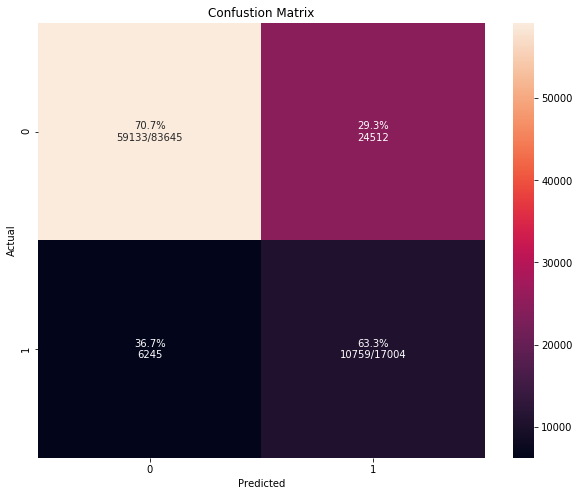

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.title("Confustion Matrix")
#     plt.savefig(filename)

plot_confusion_matrix(test['click'].as_data_frame().as_matrix(), predictions['predict'].as_data_frame().as_matrix(), 'filename', [0, 1], ymap=None, figsize=(10,8))


**Notes on GLM model:**

- the train accuracy is 83%, hihger than the testing one which is 69.4%. The model does not generalise that well on new data. In a way this is expected because there are so many unique values to be considered (~170k) and it is recommended to include more data.
- training precision and recall are quite high, but the f1 score (combination of both precision and recall) is about 0.41. For classification models, it is good practice to aim for a high f1 score instead of watching the accuracy. The test f1 score = 0.41. 
- confusion matrix shows that ~30% of label 0 (non-click -- false positive) was not predicted well and about 36% of label 1 (click  -- false negative) was not predicted well. 

Next steps: 
- this model does not include any regularization like l1 or/and l2. This can be explored, but before doing that let's try another famiyl model such as tree based (xgboost). 
